# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=80 and (epoch-80)%10==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.314955, Accuracy: 9.38
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.274052, Accuracy: 11.72
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.140249, Accuracy: 17.38
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.041950, Accuracy: 21.09
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.989888, Accuracy: 23.83
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.893231, Accuracy: 26.95
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.827100, Accuracy: 29.10
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.820966, Accuracy: 27.34
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.831192, Accuracy: 29.69
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.777374, Accuracy: 32.62
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.766711, Accuracy: 32.42
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.687487, Accuracy: 35.74
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.690522, Accuracy: 38.48
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.646081, Accuracy: 39.45
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.661396, Accuracy: 37.11
Train

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.872234, Accuracy: 68.95
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.775883, Accuracy: 72.66
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.875044, Accuracy: 67.38
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.797385, Accuracy: 72.85
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.798896, Accuracy: 72.07
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.746146, Accuracy: 74.22
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.742048, Accuracy: 72.46
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.821985, Accuracy: 72.66
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.776095, Accuracy: 72.27
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.751066, Accuracy: 74.02
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.778556, Accuracy: 72.46
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.727019, Accuracy: 74.22
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.805253, Accuracy: 68.55

Validation set: Average loss: 0.8478, Accuracy: 3499/5000 (69.00%)

the time of this epoch:[19.541424036026 s]
Train Epoch: 7 [0

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.556230, Accuracy: 81.45
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.481488, Accuracy: 83.98
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.502098, Accuracy: 82.81
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.553461, Accuracy: 81.05
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.508472, Accuracy: 81.84
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.559180, Accuracy: 80.86
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.560727, Accuracy: 81.45
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.517726, Accuracy: 82.62

Validation set: Average loss: 0.6229, Accuracy: 3899/5000 (77.00%)

the time of this epoch:[19.333790063858032 s]
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.517437, Accuracy: 80.47
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.487262, Accuracy: 83.40
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.515175, Accuracy: 83.01
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.469189, Accuracy: 83.01
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.485604, Accuracy: 82.62
Train Epoc

Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.463539, Accuracy: 83.20
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.388049, Accuracy: 85.55
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.440363, Accuracy: 84.96
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.352632, Accuracy: 86.72

Validation set: Average loss: 0.5986, Accuracy: 3968/5000 (79.00%)

the time of this epoch:[19.4095196723938 s]
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.400803, Accuracy: 85.74
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.321134, Accuracy: 88.28
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.382887, Accuracy: 88.09
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.365522, Accuracy: 86.91
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.366669, Accuracy: 86.13
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.375940, Accuracy: 85.94
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.334688, Accuracy: 87.89
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.376967, Accuracy: 87.70
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.397693, Accuracy: 87.30
Train Epoch:


Validation set: Average loss: 0.4804, Accuracy: 4222/5000 (84.00%)

the time of this epoch:[19.41557478904724 s]
Train Epoch: 25 [0/50000 (0%)]	Loss: 0.293051, Accuracy: 88.48
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.273955, Accuracy: 89.45
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.269053, Accuracy: 90.43
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.308792, Accuracy: 88.48
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.278767, Accuracy: 90.62
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.323387, Accuracy: 88.09
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.258420, Accuracy: 91.21
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.310567, Accuracy: 89.45
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.249062, Accuracy: 90.23
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.354463, Accuracy: 88.48
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.353514, Accuracy: 87.70
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.312433, Accuracy: 89.06
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.333073, Accuracy: 88.28
Train Epoch

Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.216156, Accuracy: 92.77
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.264061, Accuracy: 91.80
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.279078, Accuracy: 89.26
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.190846, Accuracy: 93.95
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.237815, Accuracy: 91.80
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.264755, Accuracy: 91.21
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.236541, Accuracy: 91.60
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.229616, Accuracy: 93.75
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.277699, Accuracy: 91.41
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.247762, Accuracy: 92.19
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.237220, Accuracy: 90.82
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.253953, Accuracy: 89.84
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.248324, Accuracy: 91.02
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.238789, Accuracy: 91.41
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.243356

Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.228368, Accuracy: 91.99
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.249582, Accuracy: 90.23
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.178049, Accuracy: 93.75
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.221460, Accuracy: 91.99
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.182065, Accuracy: 94.34
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.233062, Accuracy: 91.99
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.234390, Accuracy: 91.99
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.218852, Accuracy: 91.99
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.191383, Accuracy: 92.19
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.211002, Accuracy: 92.77
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.214950, Accuracy: 93.55
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.204574, Accuracy: 91.99

Validation set: Average loss: 0.4657, Accuracy: 4265/5000 (85.00%)

the time of this epoch:[19.401935577392578 s]
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.180293, Accuracy: 93.36
Train 

Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.146459, Accuracy: 95.12
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.210438, Accuracy: 92.97
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.194824, Accuracy: 94.34
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.195181, Accuracy: 92.19
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.138439, Accuracy: 95.31
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.170373, Accuracy: 93.36
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.145351, Accuracy: 95.51
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.206292, Accuracy: 91.60

Validation set: Average loss: 0.5628, Accuracy: 4155/5000 (83.00%)

the time of this epoch:[19.31787633895874 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.167608, Accuracy: 93.36
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.127079, Accuracy: 95.12
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.163315, Accuracy: 93.55
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.153539, Accuracy: 93.75
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.152672, Accuracy: 95.31
Train Epoch

Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.147745, Accuracy: 94.53
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.150504, Accuracy: 94.53
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.129178, Accuracy: 95.31
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.165852, Accuracy: 94.53

Validation set: Average loss: 0.4315, Accuracy: 4362/5000 (87.00%)

the time of this epoch:[19.266062259674072 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.132519, Accuracy: 95.12
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.152857, Accuracy: 94.34
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.141834, Accuracy: 94.34
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.147283, Accuracy: 93.95
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.117438, Accuracy: 95.90
Train Epoch: 50 [12800/50000 (28%)]	Loss: 0.108376, Accuracy: 95.51
Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.142157, Accuracy: 94.73
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.149590, Accuracy: 94.14
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.094008, Accuracy: 96.88
Train Epoc


Validation set: Average loss: 0.4484, Accuracy: 4348/5000 (86.00%)

the time of this epoch:[19.372066736221313 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.082120, Accuracy: 96.68
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.146590, Accuracy: 94.92
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.131320, Accuracy: 96.09
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.115888, Accuracy: 96.29
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.115117, Accuracy: 95.90
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.089529, Accuracy: 96.88
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.092544, Accuracy: 95.51
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.103812, Accuracy: 96.68
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.119140, Accuracy: 95.90
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.106847, Accuracy: 96.29
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.096622, Accuracy: 96.88
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.119052, Accuracy: 96.48
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.105221, Accuracy: 96.48
Train Epoc

Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.108809, Accuracy: 95.90
Train Epoch: 62 [7680/50000 (17%)]	Loss: 0.054993, Accuracy: 98.24
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.063896, Accuracy: 98.44
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.096898, Accuracy: 97.27
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.091878, Accuracy: 96.68
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.101304, Accuracy: 96.09
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.093413, Accuracy: 96.88
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.080450, Accuracy: 97.66
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.086579, Accuracy: 97.46
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.063690, Accuracy: 97.85
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.080059, Accuracy: 97.27
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.085637, Accuracy: 97.07
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.107047, Accuracy: 96.68
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.118257, Accuracy: 96.68
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.103575

Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.077451, Accuracy: 96.68
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.076598, Accuracy: 97.07
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.104553, Accuracy: 97.07
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.057254, Accuracy: 98.05
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.102247, Accuracy: 96.88
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.079978, Accuracy: 97.66
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.043014, Accuracy: 98.83
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.099960, Accuracy: 96.29
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.060932, Accuracy: 97.85
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.082080, Accuracy: 97.66
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.064664, Accuracy: 97.85
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.088706, Accuracy: 97.07

Validation set: Average loss: 0.4446, Accuracy: 4419/5000 (88.00%)

the time of this epoch:[19.282784938812256 s]
Train Epoch: 69 [0/50000 (0%)]	Loss: 0.059091, Accuracy: 97.66
Train 

Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.048538, Accuracy: 98.44
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.059062, Accuracy: 98.05
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.050601, Accuracy: 97.85
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.043093, Accuracy: 98.24
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.070303, Accuracy: 97.07
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.050078, Accuracy: 97.46
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.044682, Accuracy: 98.24
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.066358, Accuracy: 97.85

Validation set: Average loss: 0.4799, Accuracy: 4396/5000 (87.00%)

the time of this epoch:[19.296504020690918 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.060258, Accuracy: 97.85
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.043271, Accuracy: 98.05
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.037397, Accuracy: 98.83
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.074785, Accuracy: 98.05
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.054308, Accuracy: 97.85
Train Epoc

Train Epoch: 80 [35840/50000 (80%)]	Loss: 0.046950, Accuracy: 98.63
Train Epoch: 80 [38400/50000 (85%)]	Loss: 0.035451, Accuracy: 99.02
Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.033776, Accuracy: 99.22
Train Epoch: 80 [43520/50000 (97%)]	Loss: 0.032839, Accuracy: 98.63

Validation set: Average loss: 0.4606, Accuracy: 4431/5000 (88.00%)

the time of this epoch:[19.329715490341187 s]

Test set: Average loss: 0.5009, Accuracy: 8810/10000 (88.10%)

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.030418, Accuracy: 99.22
Train Epoch: 81 [2560/50000 (6%)]	Loss: 0.044614, Accuracy: 98.44
Train Epoch: 81 [5120/50000 (11%)]	Loss: 0.043592, Accuracy: 98.05
Train Epoch: 81 [7680/50000 (17%)]	Loss: 0.045197, Accuracy: 97.85
Train Epoch: 81 [10240/50000 (23%)]	Loss: 0.034772, Accuracy: 98.44
Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.023049, Accuracy: 99.61
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.034421, Accuracy: 98.83
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.034096, Accuracy: 98.83
Train Epoch: 8

Train Epoch: 86 [43520/50000 (97%)]	Loss: 0.024277, Accuracy: 99.22

Validation set: Average loss: 0.4746, Accuracy: 4447/5000 (88.00%)

the time of this epoch:[19.354146242141724 s]
Train Epoch: 87 [0/50000 (0%)]	Loss: 0.033536, Accuracy: 98.63
Train Epoch: 87 [2560/50000 (6%)]	Loss: 0.044523, Accuracy: 98.44
Train Epoch: 87 [5120/50000 (11%)]	Loss: 0.027219, Accuracy: 99.02
Train Epoch: 87 [7680/50000 (17%)]	Loss: 0.037425, Accuracy: 98.63
Train Epoch: 87 [10240/50000 (23%)]	Loss: 0.049279, Accuracy: 98.44
Train Epoch: 87 [12800/50000 (28%)]	Loss: 0.036928, Accuracy: 98.83
Train Epoch: 87 [15360/50000 (34%)]	Loss: 0.049060, Accuracy: 98.24
Train Epoch: 87 [17920/50000 (40%)]	Loss: 0.025830, Accuracy: 99.02
Train Epoch: 87 [20480/50000 (45%)]	Loss: 0.041521, Accuracy: 99.22
Train Epoch: 87 [23040/50000 (51%)]	Loss: 0.065418, Accuracy: 97.85
Train Epoch: 87 [25600/50000 (57%)]	Loss: 0.020145, Accuracy: 99.61
Train Epoch: 87 [28160/50000 (62%)]	Loss: 0.051088, Accuracy: 98.44
Train Epoc

Train Epoch: 93 [0/50000 (0%)]	Loss: 0.024655, Accuracy: 99.22
Train Epoch: 93 [2560/50000 (6%)]	Loss: 0.035019, Accuracy: 99.02
Train Epoch: 93 [5120/50000 (11%)]	Loss: 0.033351, Accuracy: 99.02
Train Epoch: 93 [7680/50000 (17%)]	Loss: 0.040446, Accuracy: 98.24
Train Epoch: 93 [10240/50000 (23%)]	Loss: 0.021055, Accuracy: 99.22
Train Epoch: 93 [12800/50000 (28%)]	Loss: 0.024635, Accuracy: 99.41
Train Epoch: 93 [15360/50000 (34%)]	Loss: 0.033097, Accuracy: 98.44
Train Epoch: 93 [17920/50000 (40%)]	Loss: 0.027173, Accuracy: 99.02
Train Epoch: 93 [20480/50000 (45%)]	Loss: 0.012504, Accuracy: 99.41
Train Epoch: 93 [23040/50000 (51%)]	Loss: 0.024540, Accuracy: 99.41
Train Epoch: 93 [25600/50000 (57%)]	Loss: 0.026977, Accuracy: 99.22
Train Epoch: 93 [28160/50000 (62%)]	Loss: 0.020025, Accuracy: 99.22
Train Epoch: 93 [30720/50000 (68%)]	Loss: 0.030137, Accuracy: 99.41
Train Epoch: 93 [33280/50000 (74%)]	Loss: 0.034578, Accuracy: 98.44
Train Epoch: 93 [35840/50000 (80%)]	Loss: 0.014972, Accur

Train Epoch: 99 [10240/50000 (23%)]	Loss: 0.012467, Accuracy: 99.80
Train Epoch: 99 [12800/50000 (28%)]	Loss: 0.010443, Accuracy: 99.41
Train Epoch: 99 [15360/50000 (34%)]	Loss: 0.033508, Accuracy: 99.02
Train Epoch: 99 [17920/50000 (40%)]	Loss: 0.031027, Accuracy: 98.83
Train Epoch: 99 [20480/50000 (45%)]	Loss: 0.025925, Accuracy: 98.83
Train Epoch: 99 [23040/50000 (51%)]	Loss: 0.029189, Accuracy: 99.02
Train Epoch: 99 [25600/50000 (57%)]	Loss: 0.013482, Accuracy: 99.61
Train Epoch: 99 [28160/50000 (62%)]	Loss: 0.028043, Accuracy: 99.22
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.007879, Accuracy: 100.00
Train Epoch: 99 [33280/50000 (74%)]	Loss: 0.012441, Accuracy: 99.61
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.027006, Accuracy: 99.02
Train Epoch: 99 [38400/50000 (85%)]	Loss: 0.025138, Accuracy: 99.22
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.012019, Accuracy: 99.80
Train Epoch: 99 [43520/50000 (97%)]	Loss: 0.009650, Accuracy: 99.80

Validation set: Average loss: 0.4737, Accuracy

Train Epoch: 105 [12800/50000 (28%)]	Loss: 0.015044, Accuracy: 99.61
Train Epoch: 105 [15360/50000 (34%)]	Loss: 0.011420, Accuracy: 99.61
Train Epoch: 105 [17920/50000 (40%)]	Loss: 0.020637, Accuracy: 99.61
Train Epoch: 105 [20480/50000 (45%)]	Loss: 0.026064, Accuracy: 99.02
Train Epoch: 105 [23040/50000 (51%)]	Loss: 0.017416, Accuracy: 99.61
Train Epoch: 105 [25600/50000 (57%)]	Loss: 0.014070, Accuracy: 99.61
Train Epoch: 105 [28160/50000 (62%)]	Loss: 0.013194, Accuracy: 99.61
Train Epoch: 105 [30720/50000 (68%)]	Loss: 0.009009, Accuracy: 99.80
Train Epoch: 105 [33280/50000 (74%)]	Loss: 0.007522, Accuracy: 99.80
Train Epoch: 105 [35840/50000 (80%)]	Loss: 0.011912, Accuracy: 99.41
Train Epoch: 105 [38400/50000 (85%)]	Loss: 0.016450, Accuracy: 99.61
Train Epoch: 105 [40960/50000 (91%)]	Loss: 0.025464, Accuracy: 98.83
Train Epoch: 105 [43520/50000 (97%)]	Loss: 0.022932, Accuracy: 99.02

Validation set: Average loss: 0.4749, Accuracy: 4483/5000 (89.00%)

the time of this epoch:[19.2648708

Train Epoch: 111 [15360/50000 (34%)]	Loss: 0.026043, Accuracy: 99.61
Train Epoch: 111 [17920/50000 (40%)]	Loss: 0.014725, Accuracy: 99.61
Train Epoch: 111 [20480/50000 (45%)]	Loss: 0.018495, Accuracy: 99.61
Train Epoch: 111 [23040/50000 (51%)]	Loss: 0.010523, Accuracy: 99.80
Train Epoch: 111 [25600/50000 (57%)]	Loss: 0.014444, Accuracy: 99.80
Train Epoch: 111 [28160/50000 (62%)]	Loss: 0.009306, Accuracy: 99.80
Train Epoch: 111 [30720/50000 (68%)]	Loss: 0.005823, Accuracy: 99.80
Train Epoch: 111 [33280/50000 (74%)]	Loss: 0.007882, Accuracy: 99.80
Train Epoch: 111 [35840/50000 (80%)]	Loss: 0.007284, Accuracy: 99.80
Train Epoch: 111 [38400/50000 (85%)]	Loss: 0.011989, Accuracy: 99.80
Train Epoch: 111 [40960/50000 (91%)]	Loss: 0.010865, Accuracy: 99.80
Train Epoch: 111 [43520/50000 (97%)]	Loss: 0.010314, Accuracy: 99.61

Validation set: Average loss: 0.4922, Accuracy: 4467/5000 (89.00%)

the time of this epoch:[21.262932538986206 s]
Train Epoch: 112 [0/50000 (0%)]	Loss: 0.005838, Accuracy:

Train Epoch: 117 [20480/50000 (45%)]	Loss: 0.025773, Accuracy: 99.22
Train Epoch: 117 [23040/50000 (51%)]	Loss: 0.014946, Accuracy: 99.41
Train Epoch: 117 [25600/50000 (57%)]	Loss: 0.005481, Accuracy: 99.80
Train Epoch: 117 [28160/50000 (62%)]	Loss: 0.012322, Accuracy: 99.80
Train Epoch: 117 [30720/50000 (68%)]	Loss: 0.005963, Accuracy: 99.80
Train Epoch: 117 [33280/50000 (74%)]	Loss: 0.010749, Accuracy: 99.41
Train Epoch: 117 [35840/50000 (80%)]	Loss: 0.017775, Accuracy: 99.41
Train Epoch: 117 [38400/50000 (85%)]	Loss: 0.005595, Accuracy: 99.80
Train Epoch: 117 [40960/50000 (91%)]	Loss: 0.009521, Accuracy: 99.80
Train Epoch: 117 [43520/50000 (97%)]	Loss: 0.027115, Accuracy: 99.22

Validation set: Average loss: 0.4894, Accuracy: 4479/5000 (89.00%)

the time of this epoch:[19.24066925048828 s]
Train Epoch: 118 [0/50000 (0%)]	Loss: 0.009308, Accuracy: 99.61
Train Epoch: 118 [2560/50000 (6%)]	Loss: 0.004409, Accuracy: 100.00
Train Epoch: 118 [5120/50000 (11%)]	Loss: 0.007799, Accuracy: 99

Train Epoch: 123 [23040/50000 (51%)]	Loss: 0.007244, Accuracy: 99.80
Train Epoch: 123 [25600/50000 (57%)]	Loss: 0.016219, Accuracy: 99.41
Train Epoch: 123 [28160/50000 (62%)]	Loss: 0.013122, Accuracy: 99.41
Train Epoch: 123 [30720/50000 (68%)]	Loss: 0.008677, Accuracy: 99.61
Train Epoch: 123 [33280/50000 (74%)]	Loss: 0.006989, Accuracy: 99.61
Train Epoch: 123 [35840/50000 (80%)]	Loss: 0.007096, Accuracy: 99.80
Train Epoch: 123 [38400/50000 (85%)]	Loss: 0.006463, Accuracy: 99.80
Train Epoch: 123 [40960/50000 (91%)]	Loss: 0.002524, Accuracy: 100.00
Train Epoch: 123 [43520/50000 (97%)]	Loss: 0.003447, Accuracy: 100.00

Validation set: Average loss: 0.4911, Accuracy: 4480/5000 (89.00%)

the time of this epoch:[19.30624556541443 s]
Train Epoch: 124 [0/50000 (0%)]	Loss: 0.007911, Accuracy: 100.00
Train Epoch: 124 [2560/50000 (6%)]	Loss: 0.008288, Accuracy: 99.80
Train Epoch: 124 [5120/50000 (11%)]	Loss: 0.012958, Accuracy: 99.22
Train Epoch: 124 [7680/50000 (17%)]	Loss: 0.015165, Accuracy: 9

Train Epoch: 129 [28160/50000 (62%)]	Loss: 0.006303, Accuracy: 100.00
Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.002813, Accuracy: 100.00
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.001795, Accuracy: 100.00
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.004393, Accuracy: 99.80
Train Epoch: 129 [38400/50000 (85%)]	Loss: 0.005169, Accuracy: 99.80
Train Epoch: 129 [40960/50000 (91%)]	Loss: 0.010655, Accuracy: 99.61
Train Epoch: 129 [43520/50000 (97%)]	Loss: 0.012397, Accuracy: 99.80

Validation set: Average loss: 0.4847, Accuracy: 4486/5000 (89.00%)

the time of this epoch:[19.251291275024414 s]
Train Epoch: 130 [0/50000 (0%)]	Loss: 0.018034, Accuracy: 99.41
Train Epoch: 130 [2560/50000 (6%)]	Loss: 0.004162, Accuracy: 100.00
Train Epoch: 130 [5120/50000 (11%)]	Loss: 0.003758, Accuracy: 100.00
Train Epoch: 130 [7680/50000 (17%)]	Loss: 0.004308, Accuracy: 99.80
Train Epoch: 130 [10240/50000 (23%)]	Loss: 0.017775, Accuracy: 99.22
Train Epoch: 130 [12800/50000 (28%)]	Loss: 0.006291, Accuracy

Train Epoch: 135 [28160/50000 (62%)]	Loss: 0.014028, Accuracy: 99.61
Train Epoch: 135 [30720/50000 (68%)]	Loss: 0.003635, Accuracy: 100.00
Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.006124, Accuracy: 99.80
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.004097, Accuracy: 99.80
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.007999, Accuracy: 99.80
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.008547, Accuracy: 99.61
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.011360, Accuracy: 99.41

Validation set: Average loss: 0.4973, Accuracy: 4485/5000 (89.00%)

the time of this epoch:[19.216536283493042 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.002360, Accuracy: 100.00
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.008047, Accuracy: 99.41
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.003670, Accuracy: 99.80
Train Epoch: 136 [7680/50000 (17%)]	Loss: 0.004540, Accuracy: 100.00
Train Epoch: 136 [10240/50000 (23%)]	Loss: 0.003899, Accuracy: 100.00
Train Epoch: 136 [12800/50000 (28%)]	Loss: 0.017464, Accuracy:

Train Epoch: 141 [28160/50000 (62%)]	Loss: 0.003283, Accuracy: 100.00
Train Epoch: 141 [30720/50000 (68%)]	Loss: 0.014390, Accuracy: 99.61
Train Epoch: 141 [33280/50000 (74%)]	Loss: 0.007282, Accuracy: 99.80
Train Epoch: 141 [35840/50000 (80%)]	Loss: 0.002355, Accuracy: 100.00
Train Epoch: 141 [38400/50000 (85%)]	Loss: 0.004313, Accuracy: 100.00
Train Epoch: 141 [40960/50000 (91%)]	Loss: 0.006629, Accuracy: 99.61
Train Epoch: 141 [43520/50000 (97%)]	Loss: 0.002116, Accuracy: 100.00

Validation set: Average loss: 0.4957, Accuracy: 4485/5000 (89.00%)

the time of this epoch:[21.28925347328186 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.005872, Accuracy: 99.80
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.004002, Accuracy: 99.80
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.004240, Accuracy: 99.80
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.004174, Accuracy: 99.80
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.002690, Accuracy: 100.00
Train Epoch: 142 [12800/50000 (28%)]	Loss: 0.001981, Accuracy:

Train Epoch: 147 [30720/50000 (68%)]	Loss: 0.003730, Accuracy: 99.80
Train Epoch: 147 [33280/50000 (74%)]	Loss: 0.004900, Accuracy: 99.80
Train Epoch: 147 [35840/50000 (80%)]	Loss: 0.002527, Accuracy: 100.00
Train Epoch: 147 [38400/50000 (85%)]	Loss: 0.002330, Accuracy: 100.00
Train Epoch: 147 [40960/50000 (91%)]	Loss: 0.004627, Accuracy: 99.80
Train Epoch: 147 [43520/50000 (97%)]	Loss: 0.007344, Accuracy: 99.61

Validation set: Average loss: 0.4842, Accuracy: 4503/5000 (90.00%)

the time of this epoch:[19.22933316230774 s]
Train Epoch: 148 [0/50000 (0%)]	Loss: 0.001719, Accuracy: 100.00
Train Epoch: 148 [2560/50000 (6%)]	Loss: 0.001584, Accuracy: 100.00
Train Epoch: 148 [5120/50000 (11%)]	Loss: 0.012709, Accuracy: 99.61
Train Epoch: 148 [7680/50000 (17%)]	Loss: 0.002852, Accuracy: 100.00
Train Epoch: 148 [10240/50000 (23%)]	Loss: 0.001790, Accuracy: 100.00
Train Epoch: 148 [12800/50000 (28%)]	Loss: 0.004266, Accuracy: 99.80
Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.001722, Accuracy

Train Epoch: 153 [30720/50000 (68%)]	Loss: 0.006066, Accuracy: 99.61
Train Epoch: 153 [33280/50000 (74%)]	Loss: 0.001495, Accuracy: 100.00
Train Epoch: 153 [35840/50000 (80%)]	Loss: 0.007691, Accuracy: 99.80
Train Epoch: 153 [38400/50000 (85%)]	Loss: 0.001910, Accuracy: 100.00
Train Epoch: 153 [40960/50000 (91%)]	Loss: 0.003950, Accuracy: 100.00
Train Epoch: 153 [43520/50000 (97%)]	Loss: 0.003518, Accuracy: 100.00

Validation set: Average loss: 0.4926, Accuracy: 4499/5000 (89.00%)

the time of this epoch:[19.30399799346924 s]
Train Epoch: 154 [0/50000 (0%)]	Loss: 0.002727, Accuracy: 100.00
Train Epoch: 154 [2560/50000 (6%)]	Loss: 0.006411, Accuracy: 99.80
Train Epoch: 154 [5120/50000 (11%)]	Loss: 0.005892, Accuracy: 99.80
Train Epoch: 154 [7680/50000 (17%)]	Loss: 0.003900, Accuracy: 100.00
Train Epoch: 154 [10240/50000 (23%)]	Loss: 0.005473, Accuracy: 99.80
Train Epoch: 154 [12800/50000 (28%)]	Loss: 0.004494, Accuracy: 99.80
Train Epoch: 154 [15360/50000 (34%)]	Loss: 0.006798, Accuracy

Train Epoch: 159 [33280/50000 (74%)]	Loss: 0.002449, Accuracy: 100.00
Train Epoch: 159 [35840/50000 (80%)]	Loss: 0.002107, Accuracy: 100.00
Train Epoch: 159 [38400/50000 (85%)]	Loss: 0.015068, Accuracy: 99.80
Train Epoch: 159 [40960/50000 (91%)]	Loss: 0.001268, Accuracy: 100.00
Train Epoch: 159 [43520/50000 (97%)]	Loss: 0.003740, Accuracy: 99.80

Validation set: Average loss: 0.4908, Accuracy: 4493/5000 (89.00%)

the time of this epoch:[19.27860736846924 s]
Train Epoch: 160 [0/50000 (0%)]	Loss: 0.001583, Accuracy: 100.00
Train Epoch: 160 [2560/50000 (6%)]	Loss: 0.002088, Accuracy: 100.00
Train Epoch: 160 [5120/50000 (11%)]	Loss: 0.001356, Accuracy: 100.00
Train Epoch: 160 [7680/50000 (17%)]	Loss: 0.003190, Accuracy: 100.00
Train Epoch: 160 [10240/50000 (23%)]	Loss: 0.001266, Accuracy: 100.00
Train Epoch: 160 [12800/50000 (28%)]	Loss: 0.003172, Accuracy: 100.00
Train Epoch: 160 [15360/50000 (34%)]	Loss: 0.002765, Accuracy: 99.80
Train Epoch: 160 [17920/50000 (40%)]	Loss: 0.001802, Accur

Train Epoch: 165 [33280/50000 (74%)]	Loss: 0.002225, Accuracy: 100.00
Train Epoch: 165 [35840/50000 (80%)]	Loss: 0.009305, Accuracy: 99.61
Train Epoch: 165 [38400/50000 (85%)]	Loss: 0.001733, Accuracy: 100.00
Train Epoch: 165 [40960/50000 (91%)]	Loss: 0.001506, Accuracy: 100.00
Train Epoch: 165 [43520/50000 (97%)]	Loss: 0.012126, Accuracy: 99.80

Validation set: Average loss: 0.4915, Accuracy: 4491/5000 (89.00%)

the time of this epoch:[19.32468557357788 s]
Train Epoch: 166 [0/50000 (0%)]	Loss: 0.003063, Accuracy: 100.00
Train Epoch: 166 [2560/50000 (6%)]	Loss: 0.001875, Accuracy: 100.00
Train Epoch: 166 [5120/50000 (11%)]	Loss: 0.001577, Accuracy: 100.00
Train Epoch: 166 [7680/50000 (17%)]	Loss: 0.001737, Accuracy: 100.00
Train Epoch: 166 [10240/50000 (23%)]	Loss: 0.004370, Accuracy: 99.80
Train Epoch: 166 [12800/50000 (28%)]	Loss: 0.002207, Accuracy: 100.00
Train Epoch: 166 [15360/50000 (34%)]	Loss: 0.001300, Accuracy: 100.00
Train Epoch: 166 [17920/50000 (40%)]	Loss: 0.001409, Accur

Train Epoch: 171 [33280/50000 (74%)]	Loss: 0.001727, Accuracy: 100.00
Train Epoch: 171 [35840/50000 (80%)]	Loss: 0.002647, Accuracy: 100.00
Train Epoch: 171 [38400/50000 (85%)]	Loss: 0.003089, Accuracy: 100.00
Train Epoch: 171 [40960/50000 (91%)]	Loss: 0.004151, Accuracy: 99.80
Train Epoch: 171 [43520/50000 (97%)]	Loss: 0.004529, Accuracy: 99.61

Validation set: Average loss: 0.4942, Accuracy: 4498/5000 (89.00%)

the time of this epoch:[21.299870014190674 s]
Train Epoch: 172 [0/50000 (0%)]	Loss: 0.004204, Accuracy: 100.00
Train Epoch: 172 [2560/50000 (6%)]	Loss: 0.002797, Accuracy: 100.00
Train Epoch: 172 [5120/50000 (11%)]	Loss: 0.002850, Accuracy: 100.00
Train Epoch: 172 [7680/50000 (17%)]	Loss: 0.003060, Accuracy: 100.00
Train Epoch: 172 [10240/50000 (23%)]	Loss: 0.001478, Accuracy: 100.00
Train Epoch: 172 [12800/50000 (28%)]	Loss: 0.001709, Accuracy: 100.00
Train Epoch: 172 [15360/50000 (34%)]	Loss: 0.001738, Accuracy: 100.00
Train Epoch: 172 [17920/50000 (40%)]	Loss: 0.006998, Acc

Train Epoch: 177 [35840/50000 (80%)]	Loss: 0.004329, Accuracy: 100.00
Train Epoch: 177 [38400/50000 (85%)]	Loss: 0.004360, Accuracy: 99.80
Train Epoch: 177 [40960/50000 (91%)]	Loss: 0.001705, Accuracy: 100.00
Train Epoch: 177 [43520/50000 (97%)]	Loss: 0.003922, Accuracy: 99.80

Validation set: Average loss: 0.4874, Accuracy: 4500/5000 (90.00%)

the time of this epoch:[19.32066011428833 s]
Train Epoch: 178 [0/50000 (0%)]	Loss: 0.001192, Accuracy: 100.00
Train Epoch: 178 [2560/50000 (6%)]	Loss: 0.001958, Accuracy: 100.00
Train Epoch: 178 [5120/50000 (11%)]	Loss: 0.003640, Accuracy: 100.00
Train Epoch: 178 [7680/50000 (17%)]	Loss: 0.001423, Accuracy: 100.00
Train Epoch: 178 [10240/50000 (23%)]	Loss: 0.001654, Accuracy: 100.00
Train Epoch: 178 [12800/50000 (28%)]	Loss: 0.001779, Accuracy: 100.00
Train Epoch: 178 [15360/50000 (34%)]	Loss: 0.003684, Accuracy: 99.80
Train Epoch: 178 [17920/50000 (40%)]	Loss: 0.005535, Accuracy: 99.80
Train Epoch: 178 [20480/50000 (45%)]	Loss: 0.002166, Accura

Train Epoch: 183 [35840/50000 (80%)]	Loss: 0.001298, Accuracy: 100.00
Train Epoch: 183 [38400/50000 (85%)]	Loss: 0.004440, Accuracy: 99.80
Train Epoch: 183 [40960/50000 (91%)]	Loss: 0.006781, Accuracy: 99.80
Train Epoch: 183 [43520/50000 (97%)]	Loss: 0.003353, Accuracy: 100.00

Validation set: Average loss: 0.4881, Accuracy: 4498/5000 (89.00%)

the time of this epoch:[19.359567403793335 s]
Train Epoch: 184 [0/50000 (0%)]	Loss: 0.003225, Accuracy: 99.80
Train Epoch: 184 [2560/50000 (6%)]	Loss: 0.001982, Accuracy: 100.00
Train Epoch: 184 [5120/50000 (11%)]	Loss: 0.001615, Accuracy: 100.00
Train Epoch: 184 [7680/50000 (17%)]	Loss: 0.001893, Accuracy: 100.00
Train Epoch: 184 [10240/50000 (23%)]	Loss: 0.001669, Accuracy: 100.00
Train Epoch: 184 [12800/50000 (28%)]	Loss: 0.002159, Accuracy: 100.00
Train Epoch: 184 [15360/50000 (34%)]	Loss: 0.001925, Accuracy: 100.00
Train Epoch: 184 [17920/50000 (40%)]	Loss: 0.001925, Accuracy: 100.00
Train Epoch: 184 [20480/50000 (45%)]	Loss: 0.003564, Accu

Train Epoch: 189 [38400/50000 (85%)]	Loss: 0.002158, Accuracy: 100.00
Train Epoch: 189 [40960/50000 (91%)]	Loss: 0.002592, Accuracy: 100.00
Train Epoch: 189 [43520/50000 (97%)]	Loss: 0.001253, Accuracy: 100.00

Validation set: Average loss: 0.4922, Accuracy: 4505/5000 (90.00%)

the time of this epoch:[19.26194977760315 s]
Train Epoch: 190 [0/50000 (0%)]	Loss: 0.002744, Accuracy: 100.00
Train Epoch: 190 [2560/50000 (6%)]	Loss: 0.001654, Accuracy: 100.00
Train Epoch: 190 [5120/50000 (11%)]	Loss: 0.002699, Accuracy: 100.00
Train Epoch: 190 [7680/50000 (17%)]	Loss: 0.001230, Accuracy: 100.00
Train Epoch: 190 [10240/50000 (23%)]	Loss: 0.002271, Accuracy: 100.00
Train Epoch: 190 [12800/50000 (28%)]	Loss: 0.003515, Accuracy: 100.00
Train Epoch: 190 [15360/50000 (34%)]	Loss: 0.002062, Accuracy: 100.00
Train Epoch: 190 [17920/50000 (40%)]	Loss: 0.002561, Accuracy: 100.00
Train Epoch: 190 [20480/50000 (45%)]	Loss: 0.002747, Accuracy: 100.00
Train Epoch: 190 [23040/50000 (51%)]	Loss: 0.002364, Ac

Train Epoch: 195 [38400/50000 (85%)]	Loss: 0.001222, Accuracy: 100.00
Train Epoch: 195 [40960/50000 (91%)]	Loss: 0.001505, Accuracy: 100.00
Train Epoch: 195 [43520/50000 (97%)]	Loss: 0.001549, Accuracy: 100.00

Validation set: Average loss: 0.4865, Accuracy: 4496/5000 (89.00%)

the time of this epoch:[19.308362245559692 s]
Train Epoch: 196 [0/50000 (0%)]	Loss: 0.001471, Accuracy: 100.00
Train Epoch: 196 [2560/50000 (6%)]	Loss: 0.002526, Accuracy: 100.00
Train Epoch: 196 [5120/50000 (11%)]	Loss: 0.001710, Accuracy: 100.00
Train Epoch: 196 [7680/50000 (17%)]	Loss: 0.005384, Accuracy: 99.80
Train Epoch: 196 [10240/50000 (23%)]	Loss: 0.001897, Accuracy: 100.00
Train Epoch: 196 [12800/50000 (28%)]	Loss: 0.001404, Accuracy: 100.00
Train Epoch: 196 [15360/50000 (34%)]	Loss: 0.001204, Accuracy: 100.00
Train Epoch: 196 [17920/50000 (40%)]	Loss: 0.004616, Accuracy: 99.80
Train Epoch: 196 [20480/50000 (45%)]	Loss: 0.001562, Accuracy: 100.00
Train Epoch: 196 [23040/50000 (51%)]	Loss: 0.004200, Acc

Train Epoch: 201 [38400/50000 (85%)]	Loss: 0.001314, Accuracy: 100.00
Train Epoch: 201 [40960/50000 (91%)]	Loss: 0.004944, Accuracy: 99.80
Train Epoch: 201 [43520/50000 (97%)]	Loss: 0.002061, Accuracy: 100.00

Validation set: Average loss: 0.4876, Accuracy: 4500/5000 (90.00%)

the time of this epoch:[21.299612760543823 s]
Train Epoch: 202 [0/50000 (0%)]	Loss: 0.001707, Accuracy: 100.00
Train Epoch: 202 [2560/50000 (6%)]	Loss: 0.001587, Accuracy: 100.00
Train Epoch: 202 [5120/50000 (11%)]	Loss: 0.004450, Accuracy: 99.80
Train Epoch: 202 [7680/50000 (17%)]	Loss: 0.004588, Accuracy: 99.80
Train Epoch: 202 [10240/50000 (23%)]	Loss: 0.001677, Accuracy: 100.00
Train Epoch: 202 [12800/50000 (28%)]	Loss: 0.003627, Accuracy: 100.00
Train Epoch: 202 [15360/50000 (34%)]	Loss: 0.001158, Accuracy: 100.00
Train Epoch: 202 [17920/50000 (40%)]	Loss: 0.001286, Accuracy: 100.00
Train Epoch: 202 [20480/50000 (45%)]	Loss: 0.001910, Accuracy: 100.00
Train Epoch: 202 [23040/50000 (51%)]	Loss: 0.001521, Accu

Train Epoch: 207 [40960/50000 (91%)]	Loss: 0.004421, Accuracy: 99.80
Train Epoch: 207 [43520/50000 (97%)]	Loss: 0.001376, Accuracy: 100.00

Validation set: Average loss: 0.4861, Accuracy: 4505/5000 (90.00%)

the time of this epoch:[19.275564908981323 s]
Train Epoch: 208 [0/50000 (0%)]	Loss: 0.002749, Accuracy: 100.00
Train Epoch: 208 [2560/50000 (6%)]	Loss: 0.001760, Accuracy: 100.00
Train Epoch: 208 [5120/50000 (11%)]	Loss: 0.004859, Accuracy: 99.80
Train Epoch: 208 [7680/50000 (17%)]	Loss: 0.001041, Accuracy: 100.00
Train Epoch: 208 [10240/50000 (23%)]	Loss: 0.001295, Accuracy: 100.00
Train Epoch: 208 [12800/50000 (28%)]	Loss: 0.001295, Accuracy: 100.00
Train Epoch: 208 [15360/50000 (34%)]	Loss: 0.002737, Accuracy: 100.00
Train Epoch: 208 [17920/50000 (40%)]	Loss: 0.001072, Accuracy: 100.00
Train Epoch: 208 [20480/50000 (45%)]	Loss: 0.003722, Accuracy: 100.00
Train Epoch: 208 [23040/50000 (51%)]	Loss: 0.002831, Accuracy: 100.00
Train Epoch: 208 [25600/50000 (57%)]	Loss: 0.002624, Acc

Train Epoch: 213 [40960/50000 (91%)]	Loss: 0.001220, Accuracy: 100.00
Train Epoch: 213 [43520/50000 (97%)]	Loss: 0.001404, Accuracy: 100.00

Validation set: Average loss: 0.4886, Accuracy: 4506/5000 (90.00%)

the time of this epoch:[19.31926417350769 s]
Train Epoch: 214 [0/50000 (0%)]	Loss: 0.002424, Accuracy: 100.00
Train Epoch: 214 [2560/50000 (6%)]	Loss: 0.001392, Accuracy: 100.00
Train Epoch: 214 [5120/50000 (11%)]	Loss: 0.003227, Accuracy: 99.80
Train Epoch: 214 [7680/50000 (17%)]	Loss: 0.001185, Accuracy: 100.00
Train Epoch: 214 [10240/50000 (23%)]	Loss: 0.003272, Accuracy: 99.80
Train Epoch: 214 [12800/50000 (28%)]	Loss: 0.005832, Accuracy: 99.80
Train Epoch: 214 [15360/50000 (34%)]	Loss: 0.001249, Accuracy: 100.00
Train Epoch: 214 [17920/50000 (40%)]	Loss: 0.003817, Accuracy: 99.80
Train Epoch: 214 [20480/50000 (45%)]	Loss: 0.001532, Accuracy: 100.00
Train Epoch: 214 [23040/50000 (51%)]	Loss: 0.002932, Accuracy: 100.00
Train Epoch: 214 [25600/50000 (57%)]	Loss: 0.004043, Accura

Train Epoch: 219 [43520/50000 (97%)]	Loss: 0.001402, Accuracy: 100.00

Validation set: Average loss: 0.4867, Accuracy: 4514/5000 (90.00%)

the time of this epoch:[19.33060622215271 s]
Train Epoch: 220 [0/50000 (0%)]	Loss: 0.001816, Accuracy: 100.00
Train Epoch: 220 [2560/50000 (6%)]	Loss: 0.002558, Accuracy: 100.00
Train Epoch: 220 [5120/50000 (11%)]	Loss: 0.002647, Accuracy: 100.00
Train Epoch: 220 [7680/50000 (17%)]	Loss: 0.002613, Accuracy: 100.00
Train Epoch: 220 [10240/50000 (23%)]	Loss: 0.001421, Accuracy: 100.00
Train Epoch: 220 [12800/50000 (28%)]	Loss: 0.001897, Accuracy: 100.00
Train Epoch: 220 [15360/50000 (34%)]	Loss: 0.001206, Accuracy: 100.00
Train Epoch: 220 [17920/50000 (40%)]	Loss: 0.001431, Accuracy: 100.00
Train Epoch: 220 [20480/50000 (45%)]	Loss: 0.002485, Accuracy: 100.00
Train Epoch: 220 [23040/50000 (51%)]	Loss: 0.001330, Accuracy: 100.00
Train Epoch: 220 [25600/50000 (57%)]	Loss: 0.001493, Accuracy: 100.00
Train Epoch: 220 [28160/50000 (62%)]	Loss: 0.004510, Ac

Train Epoch: 225 [43520/50000 (97%)]	Loss: 0.004210, Accuracy: 100.00

Validation set: Average loss: 0.4838, Accuracy: 4517/5000 (90.00%)

the time of this epoch:[19.344021320343018 s]
Train Epoch: 226 [0/50000 (0%)]	Loss: 0.001973, Accuracy: 100.00
Train Epoch: 226 [2560/50000 (6%)]	Loss: 0.001722, Accuracy: 100.00
Train Epoch: 226 [5120/50000 (11%)]	Loss: 0.002299, Accuracy: 100.00
Train Epoch: 226 [7680/50000 (17%)]	Loss: 0.003538, Accuracy: 99.80
Train Epoch: 226 [10240/50000 (23%)]	Loss: 0.001480, Accuracy: 100.00
Train Epoch: 226 [12800/50000 (28%)]	Loss: 0.002980, Accuracy: 99.80
Train Epoch: 226 [15360/50000 (34%)]	Loss: 0.001399, Accuracy: 100.00
Train Epoch: 226 [17920/50000 (40%)]	Loss: 0.003752, Accuracy: 100.00
Train Epoch: 226 [20480/50000 (45%)]	Loss: 0.001019, Accuracy: 100.00
Train Epoch: 226 [23040/50000 (51%)]	Loss: 0.001304, Accuracy: 100.00
Train Epoch: 226 [25600/50000 (57%)]	Loss: 0.001105, Accuracy: 100.00
Train Epoch: 226 [28160/50000 (62%)]	Loss: 0.001412, Acc

Train Epoch: 231 [43520/50000 (97%)]	Loss: 0.001333, Accuracy: 100.00

Validation set: Average loss: 0.4846, Accuracy: 4513/5000 (90.00%)

the time of this epoch:[21.23811960220337 s]
Train Epoch: 232 [0/50000 (0%)]	Loss: 0.001179, Accuracy: 100.00
Train Epoch: 232 [2560/50000 (6%)]	Loss: 0.002989, Accuracy: 99.80
Train Epoch: 232 [5120/50000 (11%)]	Loss: 0.001249, Accuracy: 100.00
Train Epoch: 232 [7680/50000 (17%)]	Loss: 0.001735, Accuracy: 100.00
Train Epoch: 232 [10240/50000 (23%)]	Loss: 0.003202, Accuracy: 99.80
Train Epoch: 232 [12800/50000 (28%)]	Loss: 0.001253, Accuracy: 100.00
Train Epoch: 232 [15360/50000 (34%)]	Loss: 0.001503, Accuracy: 100.00
Train Epoch: 232 [17920/50000 (40%)]	Loss: 0.002063, Accuracy: 100.00
Train Epoch: 232 [20480/50000 (45%)]	Loss: 0.001998, Accuracy: 100.00
Train Epoch: 232 [23040/50000 (51%)]	Loss: 0.001926, Accuracy: 100.00
Train Epoch: 232 [25600/50000 (57%)]	Loss: 0.003470, Accuracy: 99.80
Train Epoch: 232 [28160/50000 (62%)]	Loss: 0.001041, Accur


Validation set: Average loss: 0.4878, Accuracy: 4513/5000 (90.00%)

the time of this epoch:[19.309979677200317 s]
Train Epoch: 238 [0/50000 (0%)]	Loss: 0.001156, Accuracy: 100.00
Train Epoch: 238 [2560/50000 (6%)]	Loss: 0.001584, Accuracy: 100.00
Train Epoch: 238 [5120/50000 (11%)]	Loss: 0.000994, Accuracy: 100.00
Train Epoch: 238 [7680/50000 (17%)]	Loss: 0.002083, Accuracy: 100.00
Train Epoch: 238 [10240/50000 (23%)]	Loss: 0.001587, Accuracy: 100.00
Train Epoch: 238 [12800/50000 (28%)]	Loss: 0.001135, Accuracy: 100.00
Train Epoch: 238 [15360/50000 (34%)]	Loss: 0.003398, Accuracy: 100.00
Train Epoch: 238 [17920/50000 (40%)]	Loss: 0.008104, Accuracy: 99.80
Train Epoch: 238 [20480/50000 (45%)]	Loss: 0.002847, Accuracy: 100.00
Train Epoch: 238 [23040/50000 (51%)]	Loss: 0.002070, Accuracy: 100.00
Train Epoch: 238 [25600/50000 (57%)]	Loss: 0.001027, Accuracy: 100.00
Train Epoch: 238 [28160/50000 (62%)]	Loss: 0.002016, Accuracy: 100.00
Train Epoch: 238 [30720/50000 (68%)]	Loss: 0.001348, Ac


Validation set: Average loss: 0.4874, Accuracy: 4507/5000 (90.00%)

the time of this epoch:[19.276659727096558 s]
Train Epoch: 244 [0/50000 (0%)]	Loss: 0.001784, Accuracy: 100.00
Train Epoch: 244 [2560/50000 (6%)]	Loss: 0.001159, Accuracy: 100.00
Train Epoch: 244 [5120/50000 (11%)]	Loss: 0.001294, Accuracy: 100.00
Train Epoch: 244 [7680/50000 (17%)]	Loss: 0.001133, Accuracy: 100.00
Train Epoch: 244 [10240/50000 (23%)]	Loss: 0.001278, Accuracy: 100.00
Train Epoch: 244 [12800/50000 (28%)]	Loss: 0.001909, Accuracy: 100.00
Train Epoch: 244 [15360/50000 (34%)]	Loss: 0.001093, Accuracy: 100.00
Train Epoch: 244 [17920/50000 (40%)]	Loss: 0.002457, Accuracy: 100.00
Train Epoch: 244 [20480/50000 (45%)]	Loss: 0.001823, Accuracy: 100.00
Train Epoch: 244 [23040/50000 (51%)]	Loss: 0.002753, Accuracy: 100.00
Train Epoch: 244 [25600/50000 (57%)]	Loss: 0.001716, Accuracy: 100.00
Train Epoch: 244 [28160/50000 (62%)]	Loss: 0.001770, Accuracy: 100.00
Train Epoch: 244 [30720/50000 (68%)]	Loss: 0.001449, A

Train Epoch: 250 [0/50000 (0%)]	Loss: 0.001180, Accuracy: 100.00
Train Epoch: 250 [2560/50000 (6%)]	Loss: 0.001927, Accuracy: 100.00
Train Epoch: 250 [5120/50000 (11%)]	Loss: 0.002020, Accuracy: 100.00
Train Epoch: 250 [7680/50000 (17%)]	Loss: 0.003536, Accuracy: 99.80
Train Epoch: 250 [10240/50000 (23%)]	Loss: 0.001476, Accuracy: 100.00
Train Epoch: 250 [12800/50000 (28%)]	Loss: 0.001663, Accuracy: 100.00
Train Epoch: 250 [15360/50000 (34%)]	Loss: 0.001465, Accuracy: 100.00
Train Epoch: 250 [17920/50000 (40%)]	Loss: 0.001300, Accuracy: 100.00
Train Epoch: 250 [20480/50000 (45%)]	Loss: 0.001112, Accuracy: 100.00
Train Epoch: 250 [23040/50000 (51%)]	Loss: 0.002430, Accuracy: 100.00
Train Epoch: 250 [25600/50000 (57%)]	Loss: 0.002730, Accuracy: 100.00
Train Epoch: 250 [28160/50000 (62%)]	Loss: 0.005246, Accuracy: 99.80
Train Epoch: 250 [30720/50000 (68%)]	Loss: 0.001407, Accuracy: 100.00
Train Epoch: 250 [33280/50000 (74%)]	Loss: 0.001809, Accuracy: 100.00
Train Epoch: 250 [35840/50000 (

Train Epoch: 256 [0/50000 (0%)]	Loss: 0.001219, Accuracy: 100.00
Train Epoch: 256 [2560/50000 (6%)]	Loss: 0.001256, Accuracy: 100.00
Train Epoch: 256 [5120/50000 (11%)]	Loss: 0.001094, Accuracy: 100.00
Train Epoch: 256 [7680/50000 (17%)]	Loss: 0.001525, Accuracy: 100.00
Train Epoch: 256 [10240/50000 (23%)]	Loss: 0.001183, Accuracy: 100.00
Train Epoch: 256 [12800/50000 (28%)]	Loss: 0.001152, Accuracy: 100.00
Train Epoch: 256 [15360/50000 (34%)]	Loss: 0.001232, Accuracy: 100.00
Train Epoch: 256 [17920/50000 (40%)]	Loss: 0.001675, Accuracy: 100.00
Train Epoch: 256 [20480/50000 (45%)]	Loss: 0.001058, Accuracy: 100.00
Train Epoch: 256 [23040/50000 (51%)]	Loss: 0.002201, Accuracy: 100.00
Train Epoch: 256 [25600/50000 (57%)]	Loss: 0.002018, Accuracy: 100.00
Train Epoch: 256 [28160/50000 (62%)]	Loss: 0.002483, Accuracy: 100.00
Train Epoch: 256 [30720/50000 (68%)]	Loss: 0.001205, Accuracy: 100.00
Train Epoch: 256 [33280/50000 (74%)]	Loss: 0.001455, Accuracy: 100.00
Train Epoch: 256 [35840/50000

Train Epoch: 262 [0/50000 (0%)]	Loss: 0.004424, Accuracy: 100.00
Train Epoch: 262 [2560/50000 (6%)]	Loss: 0.001229, Accuracy: 100.00
Train Epoch: 262 [5120/50000 (11%)]	Loss: 0.001523, Accuracy: 100.00
Train Epoch: 262 [7680/50000 (17%)]	Loss: 0.003488, Accuracy: 99.80
Train Epoch: 262 [10240/50000 (23%)]	Loss: 0.001268, Accuracy: 100.00
Train Epoch: 262 [12800/50000 (28%)]	Loss: 0.003532, Accuracy: 100.00
Train Epoch: 262 [15360/50000 (34%)]	Loss: 0.001566, Accuracy: 100.00
Train Epoch: 262 [17920/50000 (40%)]	Loss: 0.001883, Accuracy: 100.00
Train Epoch: 262 [20480/50000 (45%)]	Loss: 0.002187, Accuracy: 100.00
Train Epoch: 262 [23040/50000 (51%)]	Loss: 0.004465, Accuracy: 99.61
Train Epoch: 262 [25600/50000 (57%)]	Loss: 0.004381, Accuracy: 99.80
Train Epoch: 262 [28160/50000 (62%)]	Loss: 0.003993, Accuracy: 99.80
Train Epoch: 262 [30720/50000 (68%)]	Loss: 0.001242, Accuracy: 100.00
Train Epoch: 262 [33280/50000 (74%)]	Loss: 0.001015, Accuracy: 100.00
Train Epoch: 262 [35840/50000 (80

Train Epoch: 268 [2560/50000 (6%)]	Loss: 0.003024, Accuracy: 100.00
Train Epoch: 268 [5120/50000 (11%)]	Loss: 0.001138, Accuracy: 100.00
Train Epoch: 268 [7680/50000 (17%)]	Loss: 0.001486, Accuracy: 100.00
Train Epoch: 268 [10240/50000 (23%)]	Loss: 0.001474, Accuracy: 100.00
Train Epoch: 268 [12800/50000 (28%)]	Loss: 0.001225, Accuracy: 100.00
Train Epoch: 268 [15360/50000 (34%)]	Loss: 0.001143, Accuracy: 100.00
Train Epoch: 268 [17920/50000 (40%)]	Loss: 0.000996, Accuracy: 100.00
Train Epoch: 268 [20480/50000 (45%)]	Loss: 0.001190, Accuracy: 100.00
Train Epoch: 268 [23040/50000 (51%)]	Loss: 0.001504, Accuracy: 100.00
Train Epoch: 268 [25600/50000 (57%)]	Loss: 0.002279, Accuracy: 100.00
Train Epoch: 268 [28160/50000 (62%)]	Loss: 0.001710, Accuracy: 100.00
Train Epoch: 268 [30720/50000 (68%)]	Loss: 0.002099, Accuracy: 100.00
Train Epoch: 268 [33280/50000 (74%)]	Loss: 0.002938, Accuracy: 100.00
Train Epoch: 268 [35840/50000 (80%)]	Loss: 0.001179, Accuracy: 100.00
Train Epoch: 268 [38400/

Train Epoch: 274 [2560/50000 (6%)]	Loss: 0.000949, Accuracy: 100.00
Train Epoch: 274 [5120/50000 (11%)]	Loss: 0.001312, Accuracy: 100.00
Train Epoch: 274 [7680/50000 (17%)]	Loss: 0.003018, Accuracy: 100.00
Train Epoch: 274 [10240/50000 (23%)]	Loss: 0.001173, Accuracy: 100.00
Train Epoch: 274 [12800/50000 (28%)]	Loss: 0.000979, Accuracy: 100.00
Train Epoch: 274 [15360/50000 (34%)]	Loss: 0.001636, Accuracy: 100.00
Train Epoch: 274 [17920/50000 (40%)]	Loss: 0.002304, Accuracy: 100.00
Train Epoch: 274 [20480/50000 (45%)]	Loss: 0.004297, Accuracy: 99.80
Train Epoch: 274 [23040/50000 (51%)]	Loss: 0.001169, Accuracy: 100.00
Train Epoch: 274 [25600/50000 (57%)]	Loss: 0.004188, Accuracy: 100.00
Train Epoch: 274 [28160/50000 (62%)]	Loss: 0.001054, Accuracy: 100.00
Train Epoch: 274 [30720/50000 (68%)]	Loss: 0.001783, Accuracy: 100.00
Train Epoch: 274 [33280/50000 (74%)]	Loss: 0.001141, Accuracy: 100.00
Train Epoch: 274 [35840/50000 (80%)]	Loss: 0.001297, Accuracy: 100.00
Train Epoch: 274 [38400/5

Train Epoch: 280 [5120/50000 (11%)]	Loss: 0.001040, Accuracy: 100.00
Train Epoch: 280 [7680/50000 (17%)]	Loss: 0.001441, Accuracy: 100.00
Train Epoch: 280 [10240/50000 (23%)]	Loss: 0.002447, Accuracy: 100.00
Train Epoch: 280 [12800/50000 (28%)]	Loss: 0.006658, Accuracy: 99.80
Train Epoch: 280 [15360/50000 (34%)]	Loss: 0.001375, Accuracy: 100.00
Train Epoch: 280 [17920/50000 (40%)]	Loss: 0.006625, Accuracy: 99.80
Train Epoch: 280 [20480/50000 (45%)]	Loss: 0.007456, Accuracy: 99.80
Train Epoch: 280 [23040/50000 (51%)]	Loss: 0.002642, Accuracy: 100.00
Train Epoch: 280 [25600/50000 (57%)]	Loss: 0.003152, Accuracy: 100.00
Train Epoch: 280 [28160/50000 (62%)]	Loss: 0.001345, Accuracy: 100.00
Train Epoch: 280 [30720/50000 (68%)]	Loss: 0.001787, Accuracy: 100.00
Train Epoch: 280 [33280/50000 (74%)]	Loss: 0.001007, Accuracy: 100.00
Train Epoch: 280 [35840/50000 (80%)]	Loss: 0.001265, Accuracy: 100.00
Train Epoch: 280 [38400/50000 (85%)]	Loss: 0.001024, Accuracy: 100.00
Train Epoch: 280 [40960/5

Train Epoch: 286 [5120/50000 (11%)]	Loss: 0.001656, Accuracy: 100.00
Train Epoch: 286 [7680/50000 (17%)]	Loss: 0.000988, Accuracy: 100.00
Train Epoch: 286 [10240/50000 (23%)]	Loss: 0.001638, Accuracy: 100.00
Train Epoch: 286 [12800/50000 (28%)]	Loss: 0.001093, Accuracy: 100.00
Train Epoch: 286 [15360/50000 (34%)]	Loss: 0.001021, Accuracy: 100.00
Train Epoch: 286 [17920/50000 (40%)]	Loss: 0.001867, Accuracy: 100.00
Train Epoch: 286 [20480/50000 (45%)]	Loss: 0.001080, Accuracy: 100.00
Train Epoch: 286 [23040/50000 (51%)]	Loss: 0.001247, Accuracy: 100.00
Train Epoch: 286 [25600/50000 (57%)]	Loss: 0.002120, Accuracy: 100.00
Train Epoch: 286 [28160/50000 (62%)]	Loss: 0.001372, Accuracy: 100.00
Train Epoch: 286 [30720/50000 (68%)]	Loss: 0.001707, Accuracy: 100.00
Train Epoch: 286 [33280/50000 (74%)]	Loss: 0.001299, Accuracy: 100.00
Train Epoch: 286 [35840/50000 (80%)]	Loss: 0.001470, Accuracy: 100.00
Train Epoch: 286 [38400/50000 (85%)]	Loss: 0.002208, Accuracy: 100.00
Train Epoch: 286 [4096

Train Epoch: 292 [5120/50000 (11%)]	Loss: 0.001114, Accuracy: 100.00
Train Epoch: 292 [7680/50000 (17%)]	Loss: 0.001029, Accuracy: 100.00
Train Epoch: 292 [10240/50000 (23%)]	Loss: 0.001262, Accuracy: 100.00
Train Epoch: 292 [12800/50000 (28%)]	Loss: 0.000932, Accuracy: 100.00
Train Epoch: 292 [15360/50000 (34%)]	Loss: 0.000921, Accuracy: 100.00
Train Epoch: 292 [17920/50000 (40%)]	Loss: 0.001001, Accuracy: 100.00
Train Epoch: 292 [20480/50000 (45%)]	Loss: 0.002457, Accuracy: 100.00
Train Epoch: 292 [23040/50000 (51%)]	Loss: 0.001609, Accuracy: 100.00
Train Epoch: 292 [25600/50000 (57%)]	Loss: 0.001044, Accuracy: 100.00
Train Epoch: 292 [28160/50000 (62%)]	Loss: 0.001122, Accuracy: 100.00
Train Epoch: 292 [30720/50000 (68%)]	Loss: 0.001140, Accuracy: 100.00
Train Epoch: 292 [33280/50000 (74%)]	Loss: 0.007314, Accuracy: 99.61
Train Epoch: 292 [35840/50000 (80%)]	Loss: 0.001222, Accuracy: 100.00
Train Epoch: 292 [38400/50000 (85%)]	Loss: 0.002784, Accuracy: 100.00
Train Epoch: 292 [40960

Train Epoch: 298 [7680/50000 (17%)]	Loss: 0.001230, Accuracy: 100.00
Train Epoch: 298 [10240/50000 (23%)]	Loss: 0.001449, Accuracy: 100.00
Train Epoch: 298 [12800/50000 (28%)]	Loss: 0.002124, Accuracy: 100.00
Train Epoch: 298 [15360/50000 (34%)]	Loss: 0.001252, Accuracy: 100.00
Train Epoch: 298 [17920/50000 (40%)]	Loss: 0.003091, Accuracy: 99.80
Train Epoch: 298 [20480/50000 (45%)]	Loss: 0.001253, Accuracy: 100.00
Train Epoch: 298 [23040/50000 (51%)]	Loss: 0.001207, Accuracy: 100.00
Train Epoch: 298 [25600/50000 (57%)]	Loss: 0.001268, Accuracy: 100.00
Train Epoch: 298 [28160/50000 (62%)]	Loss: 0.001004, Accuracy: 100.00
Train Epoch: 298 [30720/50000 (68%)]	Loss: 0.001274, Accuracy: 100.00
Train Epoch: 298 [33280/50000 (74%)]	Loss: 0.001050, Accuracy: 100.00
Train Epoch: 298 [35840/50000 (80%)]	Loss: 0.001574, Accuracy: 100.00
Train Epoch: 298 [38400/50000 (85%)]	Loss: 0.002334, Accuracy: 100.00
Train Epoch: 298 [40960/50000 (91%)]	Loss: 0.001002, Accuracy: 100.00
Train Epoch: 298 [4352

Train Epoch: 304 [7680/50000 (17%)]	Loss: 0.001828, Accuracy: 100.00
Train Epoch: 304 [10240/50000 (23%)]	Loss: 0.001306, Accuracy: 100.00
Train Epoch: 304 [12800/50000 (28%)]	Loss: 0.002265, Accuracy: 100.00
Train Epoch: 304 [15360/50000 (34%)]	Loss: 0.001276, Accuracy: 100.00
Train Epoch: 304 [17920/50000 (40%)]	Loss: 0.001299, Accuracy: 100.00
Train Epoch: 304 [20480/50000 (45%)]	Loss: 0.001863, Accuracy: 100.00
Train Epoch: 304 [23040/50000 (51%)]	Loss: 0.001040, Accuracy: 100.00
Train Epoch: 304 [25600/50000 (57%)]	Loss: 0.000958, Accuracy: 100.00
Train Epoch: 304 [28160/50000 (62%)]	Loss: 0.001265, Accuracy: 100.00
Train Epoch: 304 [30720/50000 (68%)]	Loss: 0.001087, Accuracy: 100.00
Train Epoch: 304 [33280/50000 (74%)]	Loss: 0.001118, Accuracy: 100.00
Train Epoch: 304 [35840/50000 (80%)]	Loss: 0.001496, Accuracy: 100.00
Train Epoch: 304 [38400/50000 (85%)]	Loss: 0.001438, Accuracy: 100.00
Train Epoch: 304 [40960/50000 (91%)]	Loss: 0.001596, Accuracy: 100.00
Train Epoch: 304 [435

Train Epoch: 310 [10240/50000 (23%)]	Loss: 0.003372, Accuracy: 99.80
Train Epoch: 310 [12800/50000 (28%)]	Loss: 0.005069, Accuracy: 99.80
Train Epoch: 310 [15360/50000 (34%)]	Loss: 0.002019, Accuracy: 100.00
Train Epoch: 310 [17920/50000 (40%)]	Loss: 0.001248, Accuracy: 100.00
Train Epoch: 310 [20480/50000 (45%)]	Loss: 0.001231, Accuracy: 100.00
Train Epoch: 310 [23040/50000 (51%)]	Loss: 0.001525, Accuracy: 100.00
Train Epoch: 310 [25600/50000 (57%)]	Loss: 0.001063, Accuracy: 100.00
Train Epoch: 310 [28160/50000 (62%)]	Loss: 0.001337, Accuracy: 100.00
Train Epoch: 310 [30720/50000 (68%)]	Loss: 0.001035, Accuracy: 100.00
Train Epoch: 310 [33280/50000 (74%)]	Loss: 0.001068, Accuracy: 100.00
Train Epoch: 310 [35840/50000 (80%)]	Loss: 0.001437, Accuracy: 100.00
Train Epoch: 310 [38400/50000 (85%)]	Loss: 0.001275, Accuracy: 100.00
Train Epoch: 310 [40960/50000 (91%)]	Loss: 0.001489, Accuracy: 100.00
Train Epoch: 310 [43520/50000 (97%)]	Loss: 0.001422, Accuracy: 100.00

Validation set: Avera

Train Epoch: 316 [10240/50000 (23%)]	Loss: 0.001017, Accuracy: 100.00
Train Epoch: 316 [12800/50000 (28%)]	Loss: 0.005035, Accuracy: 99.80
Train Epoch: 316 [15360/50000 (34%)]	Loss: 0.001151, Accuracy: 100.00
Train Epoch: 316 [17920/50000 (40%)]	Loss: 0.001274, Accuracy: 100.00
Train Epoch: 316 [20480/50000 (45%)]	Loss: 0.001267, Accuracy: 100.00
Train Epoch: 316 [23040/50000 (51%)]	Loss: 0.001220, Accuracy: 100.00
Train Epoch: 316 [25600/50000 (57%)]	Loss: 0.001292, Accuracy: 100.00
Train Epoch: 316 [28160/50000 (62%)]	Loss: 0.001173, Accuracy: 100.00
Train Epoch: 316 [30720/50000 (68%)]	Loss: 0.000980, Accuracy: 100.00
Train Epoch: 316 [33280/50000 (74%)]	Loss: 0.001552, Accuracy: 100.00
Train Epoch: 316 [35840/50000 (80%)]	Loss: 0.002955, Accuracy: 99.80
Train Epoch: 316 [38400/50000 (85%)]	Loss: 0.002293, Accuracy: 100.00
Train Epoch: 316 [40960/50000 (91%)]	Loss: 0.001093, Accuracy: 100.00
Train Epoch: 316 [43520/50000 (97%)]	Loss: 0.001085, Accuracy: 100.00

Validation set: Avera

Train Epoch: 322 [10240/50000 (23%)]	Loss: 0.001230, Accuracy: 100.00
Train Epoch: 322 [12800/50000 (28%)]	Loss: 0.001301, Accuracy: 100.00
Train Epoch: 322 [15360/50000 (34%)]	Loss: 0.001698, Accuracy: 100.00
Train Epoch: 322 [17920/50000 (40%)]	Loss: 0.001306, Accuracy: 100.00
Train Epoch: 322 [20480/50000 (45%)]	Loss: 0.001469, Accuracy: 100.00
Train Epoch: 322 [23040/50000 (51%)]	Loss: 0.001357, Accuracy: 100.00
Train Epoch: 322 [25600/50000 (57%)]	Loss: 0.003263, Accuracy: 99.80
Train Epoch: 322 [28160/50000 (62%)]	Loss: 0.002709, Accuracy: 100.00
Train Epoch: 322 [30720/50000 (68%)]	Loss: 0.001032, Accuracy: 100.00
Train Epoch: 322 [33280/50000 (74%)]	Loss: 0.001224, Accuracy: 100.00
Train Epoch: 322 [35840/50000 (80%)]	Loss: 0.005270, Accuracy: 99.80
Train Epoch: 322 [38400/50000 (85%)]	Loss: 0.001705, Accuracy: 100.00
Train Epoch: 322 [40960/50000 (91%)]	Loss: 0.004950, Accuracy: 99.80
Train Epoch: 322 [43520/50000 (97%)]	Loss: 0.004711, Accuracy: 99.80

Validation set: Average

Train Epoch: 328 [12800/50000 (28%)]	Loss: 0.003423, Accuracy: 100.00
Train Epoch: 328 [15360/50000 (34%)]	Loss: 0.001246, Accuracy: 100.00
Train Epoch: 328 [17920/50000 (40%)]	Loss: 0.001341, Accuracy: 100.00
Train Epoch: 328 [20480/50000 (45%)]	Loss: 0.001110, Accuracy: 100.00
Train Epoch: 328 [23040/50000 (51%)]	Loss: 0.001280, Accuracy: 100.00
Train Epoch: 328 [25600/50000 (57%)]	Loss: 0.001469, Accuracy: 100.00
Train Epoch: 328 [28160/50000 (62%)]	Loss: 0.002932, Accuracy: 100.00
Train Epoch: 328 [30720/50000 (68%)]	Loss: 0.001254, Accuracy: 100.00
Train Epoch: 328 [33280/50000 (74%)]	Loss: 0.000928, Accuracy: 100.00
Train Epoch: 328 [35840/50000 (80%)]	Loss: 0.001156, Accuracy: 100.00
Train Epoch: 328 [38400/50000 (85%)]	Loss: 0.002404, Accuracy: 100.00
Train Epoch: 328 [40960/50000 (91%)]	Loss: 0.001136, Accuracy: 100.00
Train Epoch: 328 [43520/50000 (97%)]	Loss: 0.001041, Accuracy: 100.00

Validation set: Average loss: 0.4860, Accuracy: 4512/5000 (90.00%)

the time of this epoc

Train Epoch: 334 [12800/50000 (28%)]	Loss: 0.001500, Accuracy: 100.00
Train Epoch: 334 [15360/50000 (34%)]	Loss: 0.001762, Accuracy: 100.00
Train Epoch: 334 [17920/50000 (40%)]	Loss: 0.001445, Accuracy: 100.00
Train Epoch: 334 [20480/50000 (45%)]	Loss: 0.001472, Accuracy: 100.00
Train Epoch: 334 [23040/50000 (51%)]	Loss: 0.001259, Accuracy: 100.00
Train Epoch: 334 [25600/50000 (57%)]	Loss: 0.002003, Accuracy: 100.00
Train Epoch: 334 [28160/50000 (62%)]	Loss: 0.002053, Accuracy: 100.00
Train Epoch: 334 [30720/50000 (68%)]	Loss: 0.001045, Accuracy: 100.00
Train Epoch: 334 [33280/50000 (74%)]	Loss: 0.001239, Accuracy: 100.00
Train Epoch: 334 [35840/50000 (80%)]	Loss: 0.000968, Accuracy: 100.00
Train Epoch: 334 [38400/50000 (85%)]	Loss: 0.001337, Accuracy: 100.00
Train Epoch: 334 [40960/50000 (91%)]	Loss: 0.001699, Accuracy: 100.00
Train Epoch: 334 [43520/50000 (97%)]	Loss: 0.001191, Accuracy: 100.00

Validation set: Average loss: 0.4863, Accuracy: 4509/5000 (90.00%)

the time of this epoc

Train Epoch: 340 [15360/50000 (34%)]	Loss: 0.001077, Accuracy: 100.00
Train Epoch: 340 [17920/50000 (40%)]	Loss: 0.001704, Accuracy: 100.00
Train Epoch: 340 [20480/50000 (45%)]	Loss: 0.001850, Accuracy: 100.00
Train Epoch: 340 [23040/50000 (51%)]	Loss: 0.001160, Accuracy: 100.00
Train Epoch: 340 [25600/50000 (57%)]	Loss: 0.000993, Accuracy: 100.00
Train Epoch: 340 [28160/50000 (62%)]	Loss: 0.001920, Accuracy: 100.00
Train Epoch: 340 [30720/50000 (68%)]	Loss: 0.001170, Accuracy: 100.00
Train Epoch: 340 [33280/50000 (74%)]	Loss: 0.001192, Accuracy: 100.00
Train Epoch: 340 [35840/50000 (80%)]	Loss: 0.001200, Accuracy: 100.00
Train Epoch: 340 [38400/50000 (85%)]	Loss: 0.001013, Accuracy: 100.00
Train Epoch: 340 [40960/50000 (91%)]	Loss: 0.001085, Accuracy: 100.00
Train Epoch: 340 [43520/50000 (97%)]	Loss: 0.001590, Accuracy: 100.00

Validation set: Average loss: 0.4857, Accuracy: 4515/5000 (90.00%)

the time of this epoch:[19.27850890159607 s]

Test set: Average loss: 0.5415, Accuracy: 892

Train Epoch: 346 [15360/50000 (34%)]	Loss: 0.001095, Accuracy: 100.00
Train Epoch: 346 [17920/50000 (40%)]	Loss: 0.003183, Accuracy: 99.80
Train Epoch: 346 [20480/50000 (45%)]	Loss: 0.001208, Accuracy: 100.00
Train Epoch: 346 [23040/50000 (51%)]	Loss: 0.001531, Accuracy: 100.00
Train Epoch: 346 [25600/50000 (57%)]	Loss: 0.001294, Accuracy: 100.00
Train Epoch: 346 [28160/50000 (62%)]	Loss: 0.001431, Accuracy: 100.00
Train Epoch: 346 [30720/50000 (68%)]	Loss: 0.003315, Accuracy: 100.00
Train Epoch: 346 [33280/50000 (74%)]	Loss: 0.001566, Accuracy: 100.00
Train Epoch: 346 [35840/50000 (80%)]	Loss: 0.002693, Accuracy: 100.00
Train Epoch: 346 [38400/50000 (85%)]	Loss: 0.001635, Accuracy: 100.00
Train Epoch: 346 [40960/50000 (91%)]	Loss: 0.001034, Accuracy: 100.00
Train Epoch: 346 [43520/50000 (97%)]	Loss: 0.001595, Accuracy: 100.00

Validation set: Average loss: 0.4865, Accuracy: 4509/5000 (90.00%)

the time of this epoch:[19.29975914955139 s]
Train Epoch: 347 [0/50000 (0%)]	Loss: 0.001188,

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

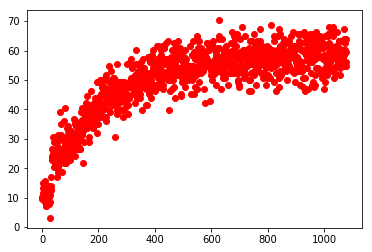

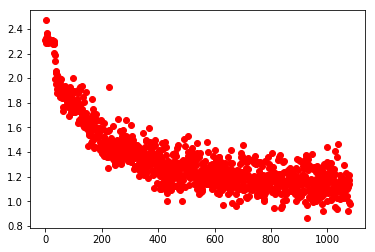

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

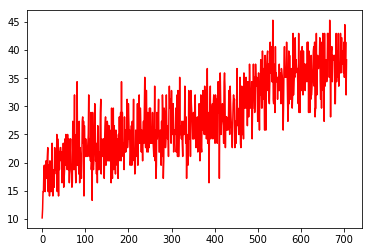

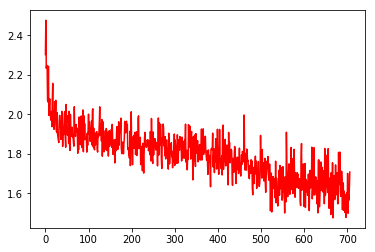

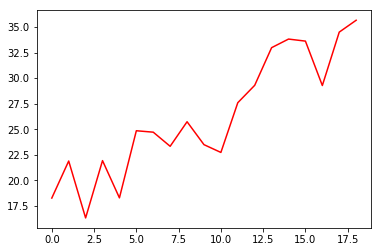

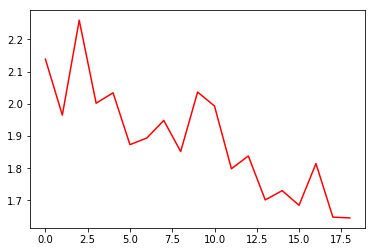

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()